<a href="https://colab.research.google.com/github/rusamentiaga/CoronaDashboard/blob/master/4_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos y transfer learning

La ventaja de los modelos de aprendizaje automático es que no es necesario crearlos desde cero, se puede partir de modelos prediseñados que se adapten a nuestro problema. Además, se puede partir de modelos pre-entrenados, donde solamente se entrenen capas específicas para adaptarlas a un problema concreto

# Dataset

Para demostrar el funcionamiento del transfer learning se va a utilizar un dataset disponible en torchvision: Cifar-10.

Se cargan los paquetes.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Se configura el dispositivo

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Se define una transformación para adaptar el dataset al tamaño de entrada que espera la red. Además, se normaliza.

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Se descarga el dataset y se configuran los cargadores.

In [4]:
batch_size = 4

#Downloading training data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

#Downloading test data
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

#Class labels

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
num_classes = len(classes)


Files already downloaded and verified
Files already downloaded and verified


Se comprueba que los ficheros están en disco.

In [5]:
!ls data/cifar-10-batches-py

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


Se puede ver el tamaño de cada batch.

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape


torch.Size([4, 3, 224, 224])

Se visualiza un batch. El dataset contiene imágenes a baja resolución de 10 clases.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, ' Frog  Frog   Cat Truck')

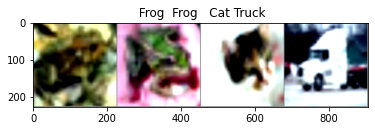

In [7]:
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images)
grid.shape

# unnormalize
grid = grid / 2 + 0.5     
plt.imshow(grid.permute(1,2,0))

plt.title(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Partiendo de un modelo prediseñado

En este caso se va a partir de [AlexNet](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py). Se puede descargar con los parámetros entrenados en [ImageNet](https://www.google.com/search?q=Imagenet).

En PyTorch hay disponibles más [modelos](https://pytorch.org/vision/stable/models.html).


In [24]:
alexnet = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Para adaptarlo al problema concreto hay que cambiar la última capa.

In [25]:
#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
alexnet.classifier[6] = torch.nn.Linear(4096,num_classes)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se define la función de entrenamiento.

In [26]:
import time

def train_model(model, criterion, optimizer):
  # Train the model
  total_step = len(trainloader)
  for epoch in range(num_epochs):
      start = time.time()
      for i, (images, labels) in enumerate(trainloader):
          images = images.to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              end = time.time()
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss}, Time: {end - start}')
              start = time.time()

Se define la función de evaluación.

In [27]:
def eval_model(model):
  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model using the test images: {} %'.format(100 * correct / total)) 

Se realiza el entrenamiento del modelo con una determinada configuración

In [28]:
# Hyperparameters
num_epochs = 1
learning_rate = 0.001
momentum = 0.9

# Model
model = alexnet.to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Train
train_model(model, criterion, optimizer)

# Eval
eval_model(model)

Epoch [1/1], Step [100/12500], Loss: 1.9646059274673462, Time: 3.9820849895477295
Epoch [1/1], Step [200/12500], Loss: 1.1386044025421143, Time: 3.8279383182525635
Epoch [1/1], Step [300/12500], Loss: 1.3463443517684937, Time: 3.8277385234832764
Epoch [1/1], Step [400/12500], Loss: 0.5709851980209351, Time: 3.8279976844787598
Epoch [1/1], Step [500/12500], Loss: 0.6927762627601624, Time: 3.833512544631958
Epoch [1/1], Step [600/12500], Loss: 1.6597859859466553, Time: 3.8321478366851807
Epoch [1/1], Step [700/12500], Loss: 1.2653231620788574, Time: 3.830467939376831
Epoch [1/1], Step [800/12500], Loss: 0.8349275588989258, Time: 3.821237802505493
Epoch [1/1], Step [900/12500], Loss: 1.2994240522384644, Time: 3.8195557594299316
Epoch [1/1], Step [1000/12500], Loss: 1.322268009185791, Time: 3.827430248260498
Epoch [1/1], Step [1100/12500], Loss: 1.5820839405059814, Time: 3.8165054321289062
Epoch [1/1], Step [1200/12500], Loss: 1.6329212188720703, Time: 3.818356513977051
Epoch [1/1], Step [

# Bloqueando capas
Durante el entrenamiento se puede bloquear el entrenamiento de ciertas capas para acelerar el proceso.


In [30]:
alexnet_lock = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
alexnet_lock.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se especifíca que no se cácule gradiente para el modelo.

In [31]:
# Freeze model weights
for param in alexnet_lock.parameters():
    param.requires_grad = False

Se añade una nueva capa de clasificación. Cuando se añade un nueva capa, por defecto se establece que sí se cálculo el gradiente y, por tanto, se permite su entrenamiento.

In [32]:
alexnet_lock.classifier = torch.nn.Sequential(
  torch.nn.Dropout(),
  torch.nn.Linear(256 * 6 * 6, 4096),
  torch.nn.ReLU(inplace=True),
  torch.nn.Dropout(),
  torch.nn.Linear(4096, 512),
  torch.nn.ReLU(inplace=True),
  torch.nn.Linear(512, num_classes),
)
alexnet_lock.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Se pueden observar los parámetros bloqueados. En otro tipo de redes y con imágenes de más resolución se pueden reducir los parámetros a entrenar en un 99%.

In [33]:
total_params = sum(p.numel() for p in alexnet_lock.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in alexnet_lock.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

42,325,322 total parameters.
39,855,626 training parameters.


Se configurarn los parámetros y realiza el entrenamiento y la evaluación.

In [35]:
# Hyperparameters
num_epochs = 1
learning_rate = 0.0001
momentum = 0.9

# Model
model = alexnet_lock.to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Train
train_model(model, criterion, optimizer)

# Eval
eval_model(model)

Epoch [1/1], Step [100/12500], Loss: 0.0046402933076024055, Time: 2.2726705074310303
Epoch [1/1], Step [200/12500], Loss: 0.10094183683395386, Time: 2.093092918395996
Epoch [1/1], Step [300/12500], Loss: 0.17370957136154175, Time: 2.095818042755127
Epoch [1/1], Step [400/12500], Loss: 0.8903066515922546, Time: 2.094352960586548
Epoch [1/1], Step [500/12500], Loss: 0.43789833784103394, Time: 2.0930287837982178
Epoch [1/1], Step [600/12500], Loss: 0.15619124472141266, Time: 2.1058857440948486
Epoch [1/1], Step [700/12500], Loss: 0.13544592261314392, Time: 2.1133477687835693
Epoch [1/1], Step [800/12500], Loss: 0.2817441523075104, Time: 2.1008429527282715
Epoch [1/1], Step [900/12500], Loss: 0.08916536718606949, Time: 2.10213303565979
Epoch [1/1], Step [1000/12500], Loss: 0.18848219513893127, Time: 2.0929722785949707
Epoch [1/1], Step [1100/12500], Loss: 0.7554062008857727, Time: 2.0915634632110596
Epoch [1/1], Step [1200/12500], Loss: 0.1251709759235382, Time: 2.0919532775878906
Epoch [1

El dataset es muy común para analizar el rendimiento de nuevos modelos. Se puede comprobar [la precisión de los nuevos modelos](https://benchmarks.ai/cifar-10).